<a href="https://colab.research.google.com/github/ritwiks9635/Optical-Character-Recognition-Model/blob/main/Handwriting_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **✍Handwriting recognition✍**

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

##**Prepare Dataset**

In [6]:
data_dir = "/content/train_v2/train"
data_csv = "/content/written_name_train_v2.csv"

In [7]:
print(len(os.listdir(data_dir)))

330961


In [8]:
df = pd.read_csv(data_csv)
df.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [9]:
df.dropna(inplace=True)

In [10]:
unreadable = df[df["IDENTITY"] == "UNREADABLE"]
unreadable.shape

(102, 2)

In [11]:
df = df[df["IDENTITY"] != "UNREADABLE"]

In [12]:
# Assuming 'df' is your DataFrame and 'FILENAME' is the column with filenames
filenames = [os.path.join(data_dir, filename) for filename in df["FILENAME"]]
df["FILENAME"]= filenames
df = df.head(50000)
df.shape

(50000, 2)

In [13]:
train_df, test_df = train_test_split(df, train_size = 0.9)

test_df, val_df = train_test_split(test_df, train_size = 0.5)

print("Total train size :: ", len(train_df))
print("Total val size :: ", len(val_df))
print("Total test size :: ", len(test_df))

Total train size ::  45000
Total val size ::  2500
Total test size ::  2500


In [14]:
def image_text(df):
    image_paths = []
    texts = []
    for i, data in df.iterrows():
        image_paths.append(data["FILENAME"])
        texts.append(data["IDENTITY"])
    return image_paths, texts


train_img_paths, train_texts = image_text(train_df)
val_img_paths, val_texts = image_text(val_df)
test_img_paths, test_texts = image_text(test_df)

In [15]:
max_len = 0
characters = set()
for text in train_texts:
    for char in text:
        characters.add(char)
    max_len = max(max_len, len(text))
print(max_len)
print(len(characters))

34
42


In [16]:
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

##**Build TF Dataset**

In [17]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [18]:
batch_size = 64
img_height = 64
img_width = 256
padding_token = 50

def preprocess_image(img_path, img_size = (img_width, img_height)):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels = 1)
    #image = tf.image.resize(image, img_size)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_text(texts):
    texts = char_to_num(tf.strings.unicode_split(texts, input_encoding="UTF-8"))
    length = tf.shape(texts)[0]
    pad_amount = max_len - length
    texts = tf.pad(texts, paddings=[[0, pad_amount]], constant_values=padding_token)
    return texts


def preprocess_data(image_paths, texts):
    image = preprocess_image(image_paths)
    texts = vectorize_text(texts)
    return {"image" : image, "label" : texts}

def prepare_dataset(image_paths, texts):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, texts))
    dataset = dataset.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [19]:
train_data = prepare_dataset(train_img_paths, train_texts)
valid_data = prepare_dataset(val_img_paths, val_texts)
test_data = prepare_dataset(test_img_paths, test_texts)

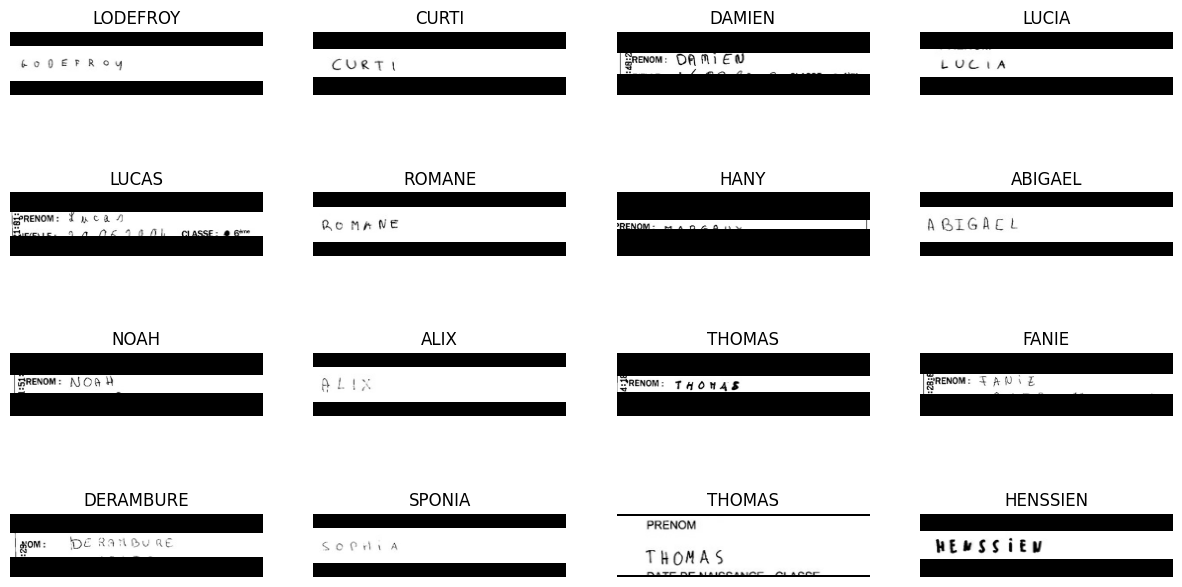

In [20]:
for data in train_data.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## **BUILD MODEL**

For a detailed understanding of the CTC loss, refer to [this post](https://distill.pub/2017/ctc/)

In [21]:
class CTCLayer(layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        input_len = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        label_len = tf.cast(tf.shape(y_true)[1], dtype = "int64")

        input_len = input_len * tf.ones(shape = (batch_len, 1), dtype = "int64")
        label_len = label_len * tf.ones(shape = (batch_len, 1), dtype = "int64")
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        self.add_loss(loss)
        return y_pred

In [22]:
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(img_width, img_height, 1), name="image")
    labels = layers.Input(name="label", shape=(None,))

    # First conv block.
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs.
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.

    x = layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 256, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 256, 64, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 128, 32, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 128, 32, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 64, 16, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 1024)       │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 64, 64)         │         65,600 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 64, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 64, 45)         │          5,805 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 64, 45)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 452,205 (1.73 MB)

 Trainable params: 452,205 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

## **Edit Distance Callbacks**

In [23]:
valid_images = []
valid_labels = []

for batch in valid_data:
    valid_images.append(batch["image"])
    valid_labels.append(batch["label"])

In [24]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(valid_images)):
            labels = valid_labels[i]
            predictions = self.prediction_model.predict(valid_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [ ]:
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.Model(
    model.input[0], model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


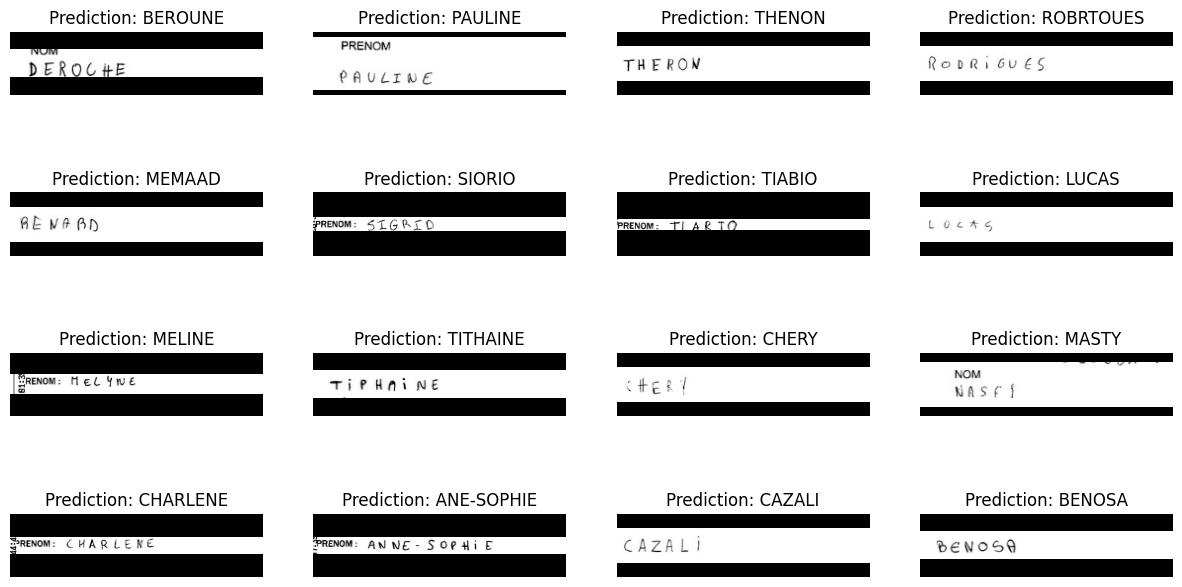

In [27]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_data.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()